> # Chapter 12. Comparing Two Samples
---



### 1. A/B Testing 


### 2.  Causality 




In [1]:
# HIDDEN
from datascience import *
import numpy as np

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
np.set_printoptions(threshold=50)

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  


+ 앞 장에서는 하나의 sample 그룹을 생성하여 관찰값과 비교
+ 이 장에서는 두개의 sample 그룹에 대해 상호비교하는 응용문제를 다룬다.

> A/B Testing
+ 어떤 두 그룹이 같은 분포로부터 샘플링 된 것인지를 판단
+ 산모흡연과 아기발육에 관한 다음 데이터를 가지고 연습해 보자.

In [2]:
baby = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp18/master/lec/baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [0]:
smoking_and_birthweight = baby.select('Maternal Smoker', 'Birth Weight')

In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


Note)
+ Overlaid histogram 도 다음과 같이 가능하다.

In [5]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


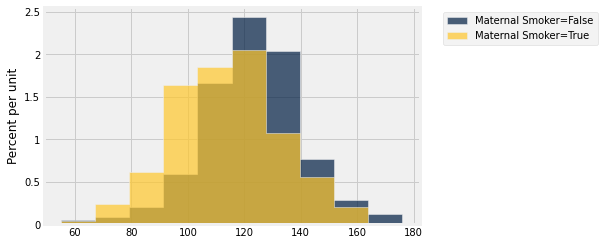

In [6]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')


+ 흡연여성의 경우 아기의 몸무게가 비교적 작아 보인다.
+ 이것이 우연에 의한 것인지를 살펴보자.

+ Null hypothesis
 - 두 그룹(흡연모, 비흡연모)의 분포는 같다. 즉, 둘의 차이는 랜덤선택에 의한 우연이다.
+ Alternative hypothesis: 
 - 흡연모의 아기 몸무게는 비흡연모의 아기 몸무게보다 작다.

+ Test Statistic
 - 두 그룹사이의 평균 몸무게 차이
 - 여기에서는 (흡연모그룹 아기 몸무게 - 비흡연모그룹 아기 몸무게) 를 사용

+ Observed statistic을 먼저 계산해보자.

In [7]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table


Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [8]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

+ 이제 Null hypothesis 에서의 statistic을 구해보자.
 - shuffle을 하면 되는데, sample()함수에서 sample_size를 주지 않으면 된다.
 - shuffle 이후 statistic을 계산하면 된다.

In [9]:
shuffled_weights = smoking_and_birthweight.sample(with_replacement = False).column(1)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Birth Weight', shuffled_weights)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Birth Weight
False,120,87
False,113,116
True,128,118
True,108,121
False,136,116
False,138,128
False,132,116
False,120,124
True,143,104
False,140,140


In [10]:
all_group_means = original_and_shuffled.group('Maternal Smoker', np.average)
all_group_means

Maternal Smoker,Birth Weight average,Shuffled Birth Weight average
False,123.085,118.952
True,113.819,120.257


In [11]:
shuffled_means = original_and_shuffled.group('Maternal Smoker', np.average).column(2)
difference = shuffled_means.item(1) - shuffled_means.item(0)
difference

1.304633057574236

이를 토대로 시뮬레이션 코드를 작성해 보자.

In [0]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    
    shuffled_weights = smoking_and_birthweight.sample(with_replacement = False).column(1)
    original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Birth Weight', shuffled_weights)

    shuffled_means = original_and_shuffled.group('Maternal Smoker', np.average).column(2)
    simulated_difference = shuffled_means.item(1) - shuffled_means.item(0)
    
    differences = np.append(differences, simulated_difference)
    


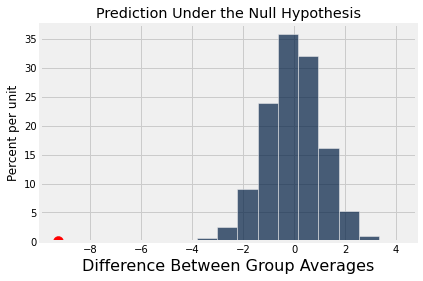

In [13]:
Table().with_column('Difference Between Group Averages', differences).hist()
plots.title('Prediction Under the Null Hypothesis');
plots.scatter(observed_difference, 0, color='red', s=100); # 실제값과 비교를 위해

In [14]:
empirical_P = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_P

0.0

- 따라서 null hypothesis가 reject된다.
- 즉, 두 그룹의 분포는 같다고 할 수 없다.

- 위 과정을 일반화하여 다른 데이터에 대해서도 사용하자.

In [0]:
def permuted_sample_average_difference(table, label, group_label, repetitions):
    
    tbl = table.select(group_label, label)
    
    differences = make_array()
    for i in np.arange(repetitions):
        shuffled = tbl.sample(with_replacement = False).column(1)
        original_and_shuffled = tbl.with_column('Shuffled Data', shuffled)

        shuffled_means = original_and_shuffled.group(group_label, np.average).column(2)
        simulated_difference = shuffled_means.item(1) - shuffled_means.item(0)
    
        differences = np.append(differences, simulated_difference)
    
    return differences   


- 간단하게 같은 데이터를 가지고 다음 가설을 테스트해 보자.
- Null Hypothesis
  - 흡연모와 비흡연모 사이에 나이에 관한 분포는 다르지 않다.

- Observed statistic

In [16]:
smoking_and_age = baby.select('Maternal Smoker', 'Maternal Age')
observed_means = smoking_and_age.group('Maternal Smoker', np.average).column(1)
observed_difference = observed_means.item(1) - observed_means.item(0)
observed_difference

-0.8076725017901509

+ Simulated statistics by shuffling

In [0]:
differences = permuted_sample_average_difference(baby, 'Maternal Age', 'Maternal Smoker', 5000)

Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

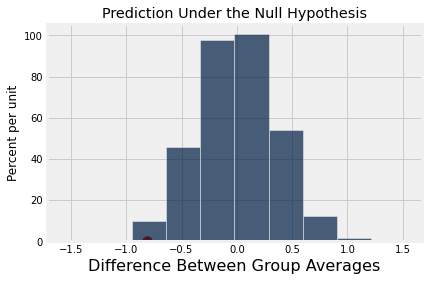

In [18]:
Table().with_column('Difference Between Group Averages', differences).hist()
plots.scatter(observed_difference, 0, color='red', s=100)
plots.title('Prediction Under the Null Hypothesis')

In [19]:
empirical_P = np.count_nonzero(differences <= observed_difference) / 5000
empirical_P

0.0104

> Deflategate 
---
+ 2015년 미 미식축구결승에서 Indianapolis Colts와 New England Patriots가 경기
+ 공의 압력은 [12.5 psi, 13.5 psi]이 정상
+ 경기 시작전 측정한 공의 압력
 - Colts 소유공 : 대부분 13.0 psi
 - Patriots 소유공 : 대부분 12.5 psi
+ Half-time에 두 명의 심판관(Clete Blakeman , Dyrol Prioleau) 이 다시 측정 
+ Patriots 공이 바람이 지나치게 빠졌다고 주장

In [20]:
football = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp18/master/lec/deflategate.csv')
football.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


- 두 심판관이 측정한 값의 평균을 사용하자.

In [21]:
football = football.with_column(
    'Combined', (football.column(1)+football.column(2))/2
    ).drop(1, 2)
football.show()

Team,Combined
Patriots,11.65
Patriots,11.025
Patriots,11.325
Patriots,10.85
Patriots,11.275
Patriots,11.775
Patriots,12.075
Patriots,11.325
Patriots,11.15
Patriots,10.7


+ 경기 시작 때 공의 압력에서 얼마가 줄어들었는지를 계산하자.

In [22]:
patriots_start = 12.5 * np.ones(11)
colts_start = 13 * np.ones(4)
start = np.append(patriots_start, colts_start)
start

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

In [23]:
drop = start - football.column('Combined')
football = football.with_column('Pressure Drop', drop)
football.show()

Team,Combined,Pressure Drop
Patriots,11.65,0.85
Patriots,11.025,1.475
Patriots,11.325,1.175
Patriots,10.85,1.65
Patriots,11.275,1.225
Patriots,11.775,0.725
Patriots,12.075,0.425
Patriots,11.325,1.175
Patriots,11.15,1.35
Patriots,10.7,1.8


+ Observed statistic

In [24]:
football = football.drop('Combined')
football.group('Team', np.average)

Team,Pressure Drop average
Colts,0.46875
Patriots,1.20227


In [25]:
observed_means = football.group('Team', np.average).column(1)

observed_difference = observed_means.item(1) - observed_means.item(0)
observed_difference

0.733522727272728

- Simulated statistics

In [0]:
def permuted_sample_average_difference(table, label, group_label, repetitions):
    
    tbl = table.select(group_label, label)
    
    differences = make_array()
    for i in np.arange(repetitions):
        shuffled = tbl.sample(with_replacement = False).column(1)
        original_and_shuffled = tbl.with_column('Shuffled Data', shuffled)

        shuffled_means = original_and_shuffled.group(group_label, np.average).column(2)
        simulated_difference = shuffled_means.item(1) - shuffled_means.item(0)
    
        differences = np.append(differences, simulated_difference)
    
    return differences   


In [0]:
differences = permuted_sample_average_difference(football, 'Pressure Drop', 'Team', 10000)

Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

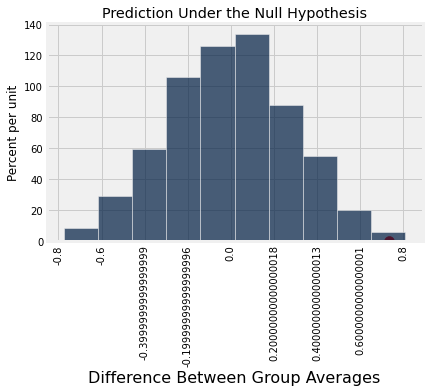

In [30]:
Table().with_column('Difference Between Group Averages', differences).hist()
plots.scatter(observed_difference, 0, color='red', s=100)
plots.title('Prediction Under the Null Hypothesis')


In [31]:
empirical_P = np.count_nonzero(differences >= observed_difference) / 10000
empirical_P

0.0022

> ### Recap
---

+ A/B Testing
 - 두 그룹의 분포에 대한 비교
 - shuffle